### Python libs

In [22]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import preprocessing
import pydotplus

### Data import

#### Read data

In [2]:
BF_logs = pd.read_pickle('./data/BF_logs.p')
Normal_logs = pd.read_pickle('./data/Normal_logs.p')
BF_logs.shape, Normal_logs.shape

((64031, 13), (12000, 13))

#### Concatenate

In [3]:
all_data = pd.concat([BF_logs, Normal_logs])
all_data.shape

(76031, 13)

### Preparation

#### Prepare

In [4]:
# if respsize is -, then 0
all_data = all_data.replace('-',0)

In [5]:
print(all_data.info())
print(all_data['label'].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76031 entries, 0 to 11999
Data columns (total 13 columns):
status        76031 non-null object
respsize      76031 non-null object
timed         76031 non-null object
date          76031 non-null object
hour          76031 non-null object
minute        76031 non-null object
seconds       76031 non-null object
protocol      76031 non-null object
username      76031 non-null object
password      76031 non-null object
ip_address    76031 non-null object
comment       76031 non-null object
label         76031 non-null object
dtypes: object(13)
memory usage: 8.1+ MB
None
count     76031
unique        2
top           1
freq      64031
Name: label, dtype: object


#### Features & Target

In [6]:
train = all_data.loc[:,['status','respsize','timed']]
train_ip = all_data.loc[:,['status','respsize','timed','ip_address']]
# target is always the label
target = all_data.label

In [7]:
# Special process for train_ip : transform string variable to numbers
le = preprocessing.LabelEncoder()
train_ip['ip_address'] = le.fit_transform(train_ip['ip_address']) 
train_ip.head()

,status,respsize,timed,ip_address
0,200,1040,312,332
1,200,945,14,332
2,200,34463,9,332
3,200,1040,2,1419
4,200,945,9,1419


### Detection

#### Evaluation rules

In [8]:
# evaluation indicators
from sklearn import metrics
def performance(y_test,y_pred):
    print ("Accuracy:", round(metrics.accuracy_score(y_test, y_pred),3))
    print ("Precision:", round(metrics.precision_score(y_test, y_pred, pos_label='1'),3))
    print ("Recall:", round(metrics.recall_score(y_test, y_pred, pos_label='1'),3))
    print ("F1:", round(metrics.f1_score(y_test,y_pred, pos_label='1'),3))
#     print ("metrics.confusion_matrix:")
#     print (metrics.confusion_matrix(y_test, y_pred))

In [9]:
# Show confusion matrix
from sklearn import metrics
def plot_cm(cm, labels):
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  # Derp, I'm sure there's a better way
    print ('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print ("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))
    # Thanks kermit666 from stackoverflow :)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

#### Without ip_address

In [10]:
# data split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train.values, target.values, test_size=0.3, random_state=0)

#### 1. Decision Tree

The result of cross validation is:
 [0.84008417 0.83966855 0.84585032 0.84058924 0.84348284 0.83861634
 0.84321978 0.8408523  0.83782717 0.82309615] 

Confusion Matrix Stats
no attaque/no attaque: 5.24% (191/3643)
no attaque/attaque: 94.76% (3452/3643)
attaque/no attaque: 1.43% (274/19167)
attaque/attaque: 98.57% (18893/19167)


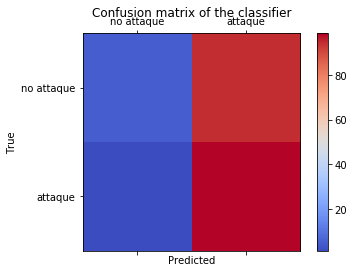

Accuracy: 0.837
Precision: 0.846
Recall: 0.986
F1: 0.91


In [11]:
# classifier
clf = tree.DecisionTreeClassifier()
# cross validation
print('The result of cross validation is:\n',cross_validation.cross_val_score(clf, X = train.values, y = target.values, cv = 10),'\n')
# training
clf = clf.fit(X_train, y_train)
# classification
y_pred = clf.predict(X_test)
# confusion matrix
labels = ['no attaque', 'attaque']
cm = metrics.confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)
# performance
performance(y_test, y_pred)

In [12]:
# # Visualization
# dot_data = tree.export_graphviz(clf, out_file=None)
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf('./data/test.png')

#### 2.Logistic

The result of cross validation is:
 [0.84218832 0.84216757 0.84216757 0.84216757 0.84216757 0.84216757
 0.84216757 0.84216757 0.84216757 0.84216757] 

Confusion Matrix Stats
no attaque/no attaque: 0.00% (0/3643)
no attaque/attaque: 100.00% (3643/3643)
attaque/no attaque: 0.00% (0/19167)
attaque/attaque: 100.00% (19167/19167)


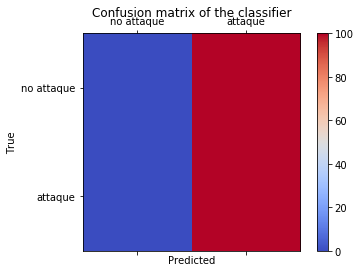

Accuracy: 0.84
Precision: 0.84
Recall: 1.0
F1: 0.913


In [13]:
# classifier
clf_log = LogisticRegression()
# cross validation
print('The result of cross validation is:\n',cross_validation.cross_val_score(clf_log, X = train.values, y = target.values, cv = 10),'\n')
# training
clf_log = clf_log.fit(X_train, y_train)
# classification
y_pred = clf_log.predict(X_test)
# confusion matrix
labels = ['no attaque', 'attaque']
cm = metrics.confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)
# performance
performance(y_test, y_pred)

#### 3.RandomForest

The result of cross validation is:
 [0.84074171 0.83966855 0.84690254 0.84348284 0.84374589 0.83966855
 0.84532421 0.84098382 0.83927397 0.82559516] 

Confusion Matrix Stats
no attaque/no attaque: 4.91% (179/3643)
no attaque/attaque: 95.09% (3464/3643)
attaque/no attaque: 1.05% (202/19167)
attaque/attaque: 98.95% (18965/19167)


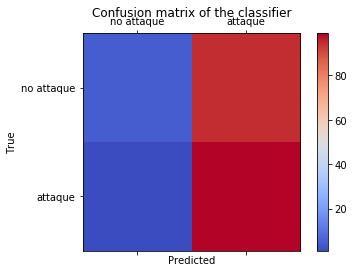

Accuracy: 0.839
Precision: 0.846
Recall: 0.989
F1: 0.912


In [18]:
# classifier
clf_rf = RandomForestClassifier()
# cross validation
print('The result of cross validation is:\n',cross_validation.cross_val_score(clf_rf, X = train.values, y = target.values, cv = 10),'\n')
# training
clf_rf = clf_rf.fit(X_train, y_train)
# classification
y_pred = clf_rf.predict(X_test)
# confusion matrix
labels = ['no attaque', 'attaque']
cm = metrics.confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)
# performance
performance(y_test, y_pred)

#### 4.Adaboost

The result of cross validation is:
 [0.8460021  0.84308825 0.84216757 0.84216757 0.84216757 0.84400894
 0.84216757 0.84374589 0.84216757 0.84177298] 

Confusion Matrix Stats
no attaque/no attaque: 0.00% (0/3643)
no attaque/attaque: 100.00% (3643/3643)
attaque/no attaque: 0.00% (0/19167)
attaque/attaque: 100.00% (19167/19167)


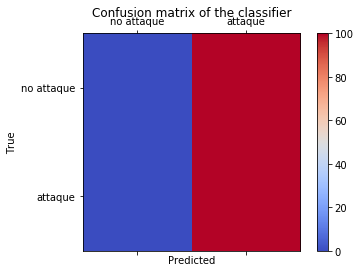

Accuracy: 0.84
Precision: 0.84
Recall: 1.0
F1: 0.913


In [23]:
# classifier
clf_ada = AdaBoostClassifier(n_estimators=100)
# cross validation
print('The result of cross validation is:\n',cross_validation.cross_val_score(clf_ada, X = train.values, y = target.values, cv = 10),'\n')
# training
clf_ada = clf_ada.fit(X_train, y_train)
# classification
y_pred = clf_ada.predict(X_test)
# confusion matrix
labels = ['no attaque', 'attaque']
cm = metrics.confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)
# performance
performance(y_test, y_pred)

#### 5.SVM (Warning: take too much time)

In [ ]:
# # classifier
# clf_svm = svm.SVC(kernel='linear', C=1)
# # cross validation
# print('The result of cross validation is:\n',cross_validation.cross_val_score(clf_svm, X = train.values, y = target.values, cv = 10),'\n')
# # training
# clf_svm = clf_svm.fit(X_train, y_train)
# # classification
# y_pred = clf_svm.predict(X_test)
# # confusion matrix
# labels = ['no attaque', 'attaque']
# cm = metrics.confusion_matrix(y_test, y_pred)
# plot_cm(cm, labels)
# # performance
# performance(y_test, y_pred)

#### With ip_address

In [19]:
# data split
X_train_ip, X_test_ip, y_train_ip, y_test_ip = cross_validation.train_test_split(train_ip.values, target.values, test_size=0.3, random_state=0)

#### 1.Decision Tree

The result of cross validation is:
 [0.99921094 0.99921084 1.         0.99921084 0.99842168 1.
 0.99842168 0.99842168 1.         0.99842168]
Confusion Matrix Stats
no attaque/no attaque: 100.00% (3643/3643)
no attaque/attaque: 0.00% (0/3643)
attaque/no attaque: 0.00% (0/19167)
attaque/attaque: 100.00% (19167/19167)


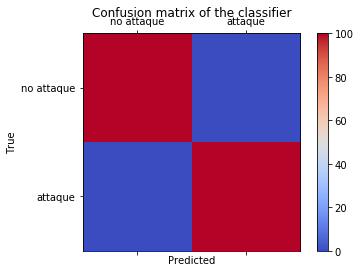

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


In [21]:
# classifier
clf_ip = tree.DecisionTreeClassifier()
# cross validation
print('The result of cross validation is:\n',cross_validation.cross_val_score(clf_ip, X = train_ip.values, y = target.values, cv = 10))
# training
clf_ip = clf_ip.fit(X_train_ip, y_train_ip)
# classification
y_pred_ip = clf_ip.predict(X_test_ip)
# confusion matrix
labels = ['no attaque', 'attaque']
cm_ip = metrics.confusion_matrix(y_test_ip, y_pred_ip)
plot_cm(cm_ip, labels)
# performance
performance(y_test_ip, y_pred_ip)